In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from module.periocular_cnn import *
from module.iris_preprocessing import load_UBIPr, load_CASIA, load_UBIPr_peri

# Load Dataset

In [5]:
img_p_cl = 15

In [80]:
iris_data_test, iris_label_test = load_UBIPr('Iris-Dataset/UBIPr', img_p_cl)

  0%|          | 0/7080 [00:00<?, ?it/s]

In [6]:
iris_data, iris_label, img_label = load_UBIPr_peri('Iris-Dataset/UBIPr_both', img_p_cl)

  0%|          | 0/3870 [00:00<?, ?it/s]

In [3]:
iris_data, iris_label = load_CASIA('Iris-Dataset/CASIA-Iris-Lamp', img_p_cl)

  0%|          | 0/411 [00:00<?, ?it/s]

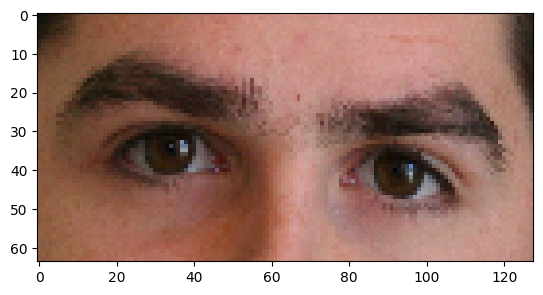

In [37]:
plt.imshow(iris_data[15].astype(int))

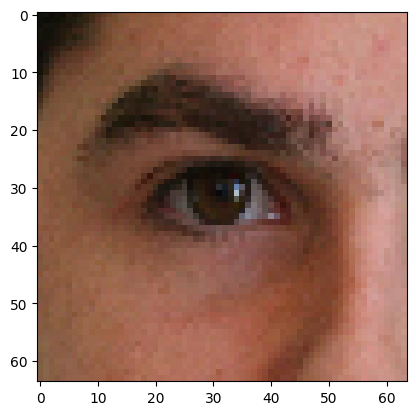

In [59]:
plt.imshow(iris_data_test[30].astype(int))

In [68]:
iris_label_test = np.array([char[:-1] for char in iris_label_test[0]])

In [69]:
iris_label_test_temp = (np.unique(iris_label_test).astype(int) + 1).astype(str)

In [76]:
iris_label_test_temp = np.array([char.zfill(3) for char in iris_label_test_temp])

In [77]:
iris_label_temp = np.unique(iris_label)

In [78]:
diff_label = [label if label not in iris_label_test_temp else 'None' for label in iris_label_temp]
print(np.unique(diff_label)[:-1])

['013' '027' '028' '030' '039' '099' '118' '136' '161' '185' '204' '205'
 '214' '224' '225' '226' '227' '228' '230' '232' '236' '252' '259' '260'
 '261']


In [79]:
diff_label = [label if label not in iris_label_temp else 'None' for label in iris_label_test_temp]
print(np.unique(diff_label)[:-1])

['130' '163' '213']


# Preprocessing

In [81]:
iris_data, iris_label, img_label = combine_LR(iris_data, iris_label, int(len(iris_data)/(2*img_p_cl)), img_p_cl)

In [82]:
X_pair, y_pair, label_pair = make_pairs(iris_data.astype(int), iris_label.astype(int), img_label, 5)

In [83]:
X_train_pair, X_test_pair, y_train_pair, y_test_pair, label_train_pair, label_test_pair = train_test_split(X_pair, y_pair, label_pair, test_size=0.2)

In [10]:
# X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(iris_data, iris_label, img_label, test_size=0.2, stratify=iris_label)
# X_train_pair, y_train_pair, label_train_pair = make_pairs(X_train, y_train.astype(int), label_train, 5)
# X_test_pair, y_test_pair, label_test_pair = make_pairs(X_test, y_test.astype(int), label_test, 1)

# VGG16 Model

In [84]:
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

In [85]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

In [86]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 128, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 128, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 32, 128)       0     

In [87]:
# from keras.utils.vis_utils import plot_model

# # Generate a plot of the model
# plot_model(model_vgg, show_shapes=True, show_layer_names=True)

In [88]:
# reset the default graph
tf.compat.v1.reset_default_graph()

# create a new session
sess = tf.compat.v1.Session()

In [89]:
# with tf.device('/cpu:0'):
#     X_train_a = tf.convert_to_tensor(vgg16_preprocess_input(X_train_pair[:, 0]), np.float32)
#     X_train_b = tf.convert_to_tensor(vgg16_preprocess_input(X_train_pair[:, 1]), np.float32)
#     y_train_final = tf.convert_to_tensor(y_train_pair.reshape(-1,1), np.float32)

#     X_test_a = tf.convert_to_tensor(vgg16_preprocess_input(X_test_pair[:, 0]), np.float32)
#     X_test_b = tf.convert_to_tensor(vgg16_preprocess_input(X_test_pair[:, 1]), np.float32)
#     y_test_final = tf.convert_to_tensor(y_test_pair.reshape(-1,1), np.float32)

In [90]:
X_train_a = vgg16_preprocess_input(X_train_pair[:, 0])
X_train_b = vgg16_preprocess_input(X_train_pair[:, 1])
y_train_final = y_train_pair.reshape(-1)

X_test_a = vgg16_preprocess_input(X_test_pair[:, 0])
X_test_b = vgg16_preprocess_input(X_test_pair[:, 1])
y_test_final = y_test_pair.reshape(-1)

In [91]:
with tf.device('/cpu:0'):
    features_train_a = model_vgg.predict(X_train_a)
    features_train_b = model_vgg.predict(X_train_b)
    features_test_a = model_vgg.predict(X_test_a)
    features_test_b = model_vgg.predict(X_test_b)

222/222 [==============================] - 85s 381ms/step


In [92]:
# # save the features to a file
# np.savez('temp_data/features/features_segAny_ubipr.npz', 
#          features_train_a=features_train_a, 
#          features_train_b=features_train_b,
#          label_train=y_train_final, 
#          img_label_train=label_train_pair,
         
#          features_test_a=features_test_a, 
#          features_test_b=features_test_b,
#          label_test=y_test_final,
#          img_label_test=label_test_pair)

In [93]:
# load the features from the file
with np.load('temp_data/features/features_segAny_ubipr.npz') as data:
    features_train_a = data['features_train_a']
    features_train_b = data['features_train_b']
    y_train_final = data['label_train']
    img_label_train = data['img_label_train']
    
    features_test_a = data['features_test_a']
    features_test_b = data['features_test_b']
    y_test_final = data['label_test']
    img_label_test = data['img_label_test']

## Create all scores for score fusion with SVM

In [94]:
from module.Iris_recognition import *
from module.Periocular_recognition import *
from module.score_fusion import *
from module.iris_scores import *

In [95]:
# iris_norm_L = np.load('temp_data/iris_norm_L_all.npy')
# iris_norm_R = np.load('temp_data/iris_norm_R_all.npy')

In [96]:
# load the features from the file
with np.load('temp_data/iris_norms/irisNorm_segAny_ubipr.npz') as data:
    iris_norm_L = data['iris_norm_L']
    iris_norm_R = data['iris_norm_R']

In [98]:
fusion_scores_test = get_fusion_scores_mp(iris_norm_L, iris_norm_R, img_label_test, 15, 'fusion_scores_test_cp.pkl', 0)

  0%|          | 0/7080 [00:00<?, ?it/s]

In [99]:
fusion_scores_train = get_fusion_scores_mp(iris_norm_L, iris_norm_R, img_label_train, 15, 'fusion_scores_train_cp.pkl', 0)

  0%|          | 0/28320 [00:00<?, ?it/s]

In [17]:
fusion_scores_train

array([[[0.46991026, 0.48278285],
        [0.63803608, 0.64834257],
        [0.23407905, 0.24201602],
        [0.58883193, 0.58203168]],

       [[0.41717731, 0.44216867],
        [0.58952514, 0.61879215],
        [0.2083835 , 0.22076483],
        [0.49597556, 0.47953911]],

       [[0.38635599, 0.31000676],
        [0.55098369, 0.46797652],
        [0.19294922, 0.15490308],
        [0.52814351, 0.44547   ]],

       ...,

       [[0.46397016, 0.45658061],
        [0.62257937, 0.62137592],
        [0.23503855, 0.22798522],
        [0.53931302, 0.56646881]],

       [[0.4612985 , 0.47456171],
        [0.64006493, 0.64242879],
        [0.2391753 , 0.2400302 ],
        [0.49870983, 0.60277262]],

       [[0.47368421, 0.45002087],
        [0.65355503, 0.64200655],
        [0.2366176 , 0.22823   ],
        [0.58305197, 0.50406124]]])

In [13]:
# fusion_scores_test = np.concatenate((fusion_scores_train, fusion_scores_test), axis=0)

In [14]:
# # save the features to a file
# np.savez('temp_data/fusion_scores_enhanced_lamp.npz',
#          fusion_scores_train=fusion_scores_train, 
#          fusion_scores_test=np.concatenate((fusion_scores_train, fusion_scores_test), axis=0))

In [100]:
# save the features to a file
np.savez('temp_data/fusion_scores/fusionScores_segAny_ubipr.npz',
         fusion_scores_train=fusion_scores_train, 
         fusion_scores_test=fusion_scores_test)

In [101]:
# load the features from the file
with np.load('temp_data/fusion_scores/fusionScores_segAny_ubipr.npz') as data:
    fusion_scores_train = data['fusion_scores_train']
    fusion_scores_test = data['fusion_scores_test']

## Classification by machine learning

In [102]:
import logging

logger = logging.getLogger("sklearnex")
logger.setLevel(logging.WARNING)  # Set the logger's logging level to WARNING or higher

In [103]:
X_train_scaled, X_test_scaled = feature_preprocessing(features_train_a, features_test_a, features_train_b, features_test_b, fusion_scores_train, fusion_scores_test, use_fusion=True)

In [20]:
# X_test_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
# y_test_final = np.concatenate((y_train_final, y_test_final), axis=0)
# img_label_test = np.concatenate((img_label_train, img_label_test), axis=0)

In [104]:
# np.savez('temp_data/features/featuresFinal_segAny_ubipr.npz',
#          X_train_final=X_train_scaled,
#          y_train_final=y_train_final,
#          label_train_pair=img_label_train,
         
#          X_test_final=X_test_scaled,
#          y_test_final=y_test_final,
#          label_test_pair=img_label_test)

In [105]:
with np.load('temp_data/features/featuresFinal_segAny_ubipr.npz') as data:
    X_train_final = data['X_train_final']
    y_train_final = data['y_train_final']
    label_train_pair = data['label_train_pair']
    
    X_test_final = data['X_test_final']
    y_test_final = data['y_test_final']
    label_test_pair = data['label_test_pair']

### SVM

In [106]:
import sklearn.svm as svm

#### Search for best hyper parameter

In [29]:
param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid_search = get_best_param(X_train_scaled, y_train_final, svm.SVC(), param)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  26.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  26.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  27.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  25.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  28.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.6s
[CV] END .....................C=0.1, gamma=1, k

: 

In [ ]:
# print the best parameters and score
print("Best Score: ", grid_search.best_score_)
print("Best Estimator: ", grid_search.best_estimator_)

Best Parameters:  {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}
Best Score:  0.8922500000000001
Best Estimator:  SVC(C=10, gamma=0.01, kernel='poly')


#### SVM Training

In [107]:
# create an SVM classifier with a Gaussian kernel
clf = svm.SVC(kernel='rbf', C=10, gamma=0.0001, verbose=2)

# train the classifier
clf.fit(X_train_final, y_train_final)

SVC(C=10, gamma=0.0001, verbose=2)

#### Save Model

In [2]:
# pickle.dump(clf, open('model/svmVgg16_segAny_ubipr.pickle', 'wb'))

In [112]:
clf = pickle.load(open('model/svmVgg16_segAny_ubipr.pickle', "rb"))

#### Cross validation

In [10]:
from sklearn.model_selection import cross_validate

In [13]:
# create an SVM classifier with a Gaussian kernel
clf = svm.SVC(kernel='rbf', C=10, gamma=0.0001, verbose=2)

X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y = np.concatenate((y_train_final, y_test_final), axis=0)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

In [14]:
print('Accuracy:', scores['test_accuracy'])
print('Precision:', scores['test_precision_macro'])
print('Recall:', scores['test_recall_macro'])

Accuracy: [0.97244048 0.97244048 0.97261905 0.97119048 0.96428571]
Precision: [0.97244241 0.97244064 0.97264648 0.97119432 0.9644039 ]
Recall: [0.97244048 0.97244048 0.97261905 0.97119048 0.96428571]


#### Performance evaluation

In [113]:
y_predict = clf.predict(X_test_final)

In [114]:
from module.score_fusion import plot_cm

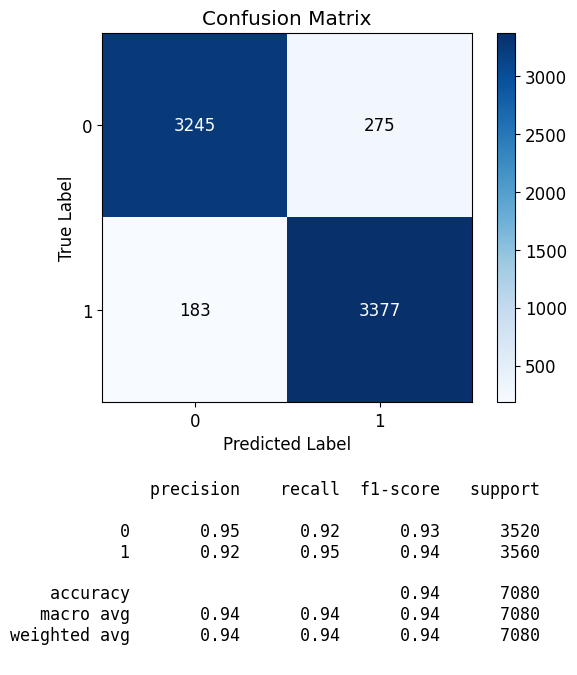

In [115]:
plot_cm(y_test_final, y_predict)

### K-Nearest Neighbor

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_final)

KNeighborsClassifier()

In [26]:
y_predict = knn.predict(X_test_scaled)

In [27]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.79      0.48      0.60      2000
           1       0.63      0.88      0.73      2000

    accuracy                           0.68      4000
   macro avg       0.71      0.68      0.66      4000
weighted avg       0.71      0.68      0.66      4000



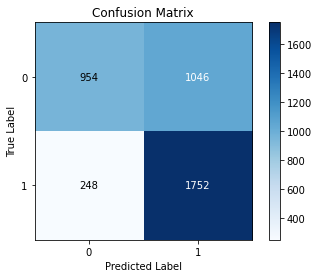

In [28]:
plot_confusion_matrix(y_test_final, y_predict)

### Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier

#### Search for best parameter

In [24]:
param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = get_best_param(X_train_final, y_train_final, RandomForestClassifier(), param)

In [ ]:
# print the best parameters and score
print("Best Score: ", grid_search.best_score_)
print("Best Estimator: ", grid_search.best_estimator_)

Best Score:  0.9399375000000001
Best Estimator:  RandomForestClassifier(min_samples_split=5, n_estimators=200)


#### Train and test

In [117]:
# Create a Random Forest classifier with 100 trees
rfc = RandomForestClassifier(min_samples_split=5, n_estimators=200)

# Train the classifier on your data
rfc.fit(X_train_final, y_train_final)

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [118]:
# pickle.dump(rfc, open('model/rfcVgg16_segAny_ubipr.pickle', 'wb'))

In [119]:
rfc = pickle.load(open('model/rfcVgg16_segAny_ubipr.pickle', "rb"))

In [120]:
# Predict the labels of the test data
y_predict = rfc.predict(X_test_final)

In [121]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      3520
           1       0.94      0.91      0.92      3560

    accuracy                           0.92      7080
   macro avg       0.92      0.92      0.92      7080
weighted avg       0.92      0.92      0.92      7080



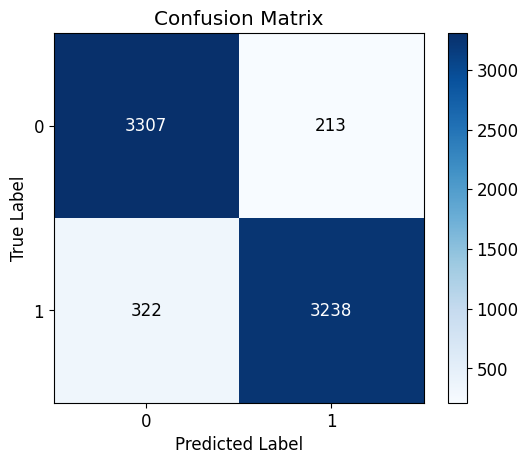

In [122]:
plot_confusion_matrix(y_test_final, y_predict)

### Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression

In [124]:
# param = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.1, 1, 10],
#     'solver': ['liblinear', 'saga']
# }
# grid_search = get_best_param(X_train_scaled, y_train_final, LogisticRegression(), param)

In [125]:
# # print the best parameters and score
# print("Best Score: ", grid_search.best_score_)
# print("Best Estimator: ", grid_search.best_estimator_)

In [126]:
# Create a Logistic Regression classifier
lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Train the classifier on your data
lr.fit(X_train_final, y_train_final)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [127]:
# pickle.dump(lr, open('model/lrVgg16_segAny_ubipr.pickle', 'wb'))

In [128]:
lr = pickle.load(open('model/lrVgg16_segAny_ubipr.pickle', "rb"))

In [129]:
# Predict the labels of the test data
y_predict = lr.predict(X_test_final)

In [130]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3520
           1       0.92      0.93      0.93      3560

    accuracy                           0.93      7080
   macro avg       0.93      0.93      0.93      7080
weighted avg       0.93      0.93      0.93      7080



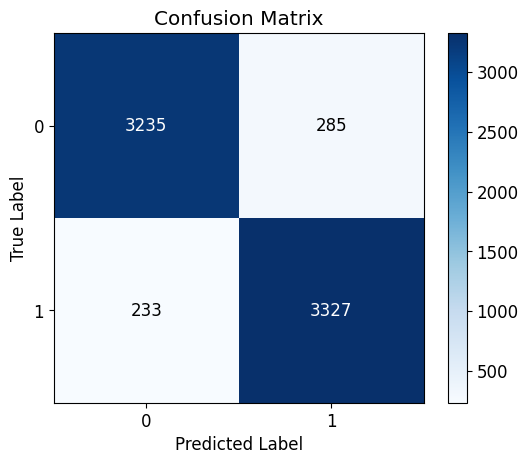

In [131]:
plot_confusion_matrix(y_test_final, y_predict)

## Classification by CNN

In [25]:
from keras.layers import Input, Flatten, Lambda, Dense
from keras.models import Model

### Pretrained CNN

In [26]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

input_dim = X_train_pair.shape[2:]

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = model_vgg(img_a)
feat_vecs_b = model_vgg(img_b)

flatten_a = Flatten()(feat_vecs_a)
flatten_b = Flatten()(feat_vecs_b)

distance = Lambda(euclidean_distance)([flatten_a, flatten_b])
outputs = Dense(1, activation="sigmoid")(distance)
model_vgg = Model(inputs=[img_a, img_b], outputs=outputs)

model_vgg.summary()

In [24]:
# compile the model
print("[INFO] compiling model...")
model_vgg.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

[INFO] compiling model...


In [47]:
set_gpu()

In [38]:
# train the model
print("[INFO] training model...")
history = model_vgg.fit(
	[X_train_a, X_train_b], y_train_final,
	batch_size=32, # reducing batch size
	epochs=100
)

[INFO] training model...
Epoch 1/100
500/500 [==============================] - 73s 146ms/step - loss: 0.6932 - accuracy: 0.4972
Epoch 2/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4972
Epoch 3/100
500/500 [==============================] - 74s 149ms/step - loss: 0.6932 - accuracy: 0.4909
Epoch 4/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4951
Epoch 5/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4936
Epoch 6/100
500/500 [==============================] - 75s 150ms/step - loss: 0.6932 - accuracy: 0.4959
Epoch 7/100
500/500 [==============================] - 75s 150ms/step - loss: 0.6932 - accuracy: 0.4921
Epoch 8/100
500/500 [==============================] - 75s 149ms/step - loss: 0.6932 - accuracy: 0.4970
Epoch 9/100
500/500 [==============================] - 75s 149ms/step - loss: 0.6932 - accuracy: 0.4984
Epoch 10/100
500/500 [=================

KeyboardInterrupt: 

### Normal CNN

In [58]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [59]:
imgA = Input(shape=X_train_pair.shape[2:])
imgB = Input(shape=X_train_pair.shape[2:])
featureExtractor = build_siamese_model(X_train_pair.shape[2:])
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [60]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [61]:
with tf.device('/cpu:0'):
    X_train_a = tf.convert_to_tensor(X_train_pair[:, 0], np.float32)
    X_train_b = tf.convert_to_tensor(X_train_pair[:, 1], np.float32)
    y_train_final = tf.convert_to_tensor(y_train_pair.reshape(-1,1), np.float32)
    
    X_test_a = tf.convert_to_tensor(X_test_pair[:, 0], np.float32)
    X_test_b = tf.convert_to_tensor(X_test_pair[:, 1], np.float32)
    y_test_final = tf.convert_to_tensor(y_test_pair.reshape(-1,1), np.float32)

In [63]:
set_gpu()

In [64]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[X_train_a, X_train_b], y_train_final,
	validation_data=([X_test_a, X_test_b], y_test_final),
	batch_size=32, 
	epochs=100)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
500/500 [==============================] - 14s 26ms/step - loss: 0.7163 - accuracy: 0.4863 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6934 - accuracy: 0.4931 - val_loss: 0.6950 - val_accuracy: 0.4970
Epoch 3/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6934 - accuracy: 0.4963 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6933 - accuracy: 0.4945 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 7/100
500/500 [==============================] - 13s 25ms/step - loss: 0.

KeyboardInterrupt: 

In [50]:
def test_model(model, X_test_a, X_test_b, y_test_final):
    # evaluate the model on the test data
    print("[INFO] evaluating model...")
    loss, accuracy = model.evaluate([X_test_a, X_test_b], y_test_final, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    # make predictions on the test data
    print("[INFO] making predictions...")
    y_pred = model.predict([X_test_a, X_test_b])
    y_pred = (y_pred > 0.5).astype(int)

    # print the classification report
    print("[INFO] classification report...")
    print(classification_report(y_test_final, y_pred))

In [52]:
set_gpu()

In [53]:
test_model(model, X_test_a, X_test_b, y_test_final)

[INFO] evaluating model...
Test Loss: 3.5463
Test Accuracy: 50.00%
[INFO] making predictions...
125/125 [==============================] - 1s 9ms/step
[INFO] classification report...
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.50      1.00      0.67      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo